In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
from data_loader import download_stock_data, save_to_csv
from feature_engineering import add_basic_features
from model import train_model


In [2]:
df = download_stock_data("AAPL", "2010-01-01", "2024-12-31")
save_to_csv(df, "../data/SP500.csv")
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
0,2010-01-04,6.440331,6.455077,6.391278,6.422877,493729600
1,2010-01-05,6.451467,6.487880,6.417461,6.458088,601904800
2,2010-01-06,6.348847,6.477046,6.342227,6.451467,552160000
3,2010-01-07,6.337110,6.379843,6.291067,6.372319,477131200
4,2010-01-08,6.379240,6.379842,6.291368,6.328683,447610800


In [3]:
from technical_indicators import add_technical_indicators

# Add RSI, Bollinger Bands, MACD
df = add_technical_indicators(df)
df.head()


Price,Date,Close,High,Low,Open,Volume,RSI,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal
19,2010-02-01,5.860126,5.898345,5.756905,5.789106,749876400,38.180199,6.624759,5.837963,-0.122075,-0.077465
20,2010-02-02,5.894132,5.907976,5.819500,5.895637,698342400,40.705427,6.611936,5.796166,-0.129448,-0.087862
21,2010-02-03,5.995546,6.024737,5.850796,5.873366,615328000,41.111439,6.581813,5.780697,-0.125659,-0.095421
22,2010-02-04,5.779476,5.969667,5.765030,5.920313,757652000,37.621101,6.583026,5.722547,-0.138495,-0.104036
23,2010-02-05,5.882093,5.898344,5.743362,5.796929,850306800,42.533144,6.567300,5.692771,-0.138788,-0.110986


In [4]:
df = add_basic_features(df)
df.head()


Price,Date,Close,High,Low,Open,Volume,RSI,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Return,MA_5,MA_10
28,2010-02-12,6.030157,6.068075,5.883300,5.961844,655468800,47.205549,6.431797,5.631432,-0.105026,-0.118973,0.008607,5.925309,5.903792
29,2010-02-16,6.121040,6.129767,6.064464,6.077103,543737600,47.369582,6.422773,5.632842,-0.084698,-0.112118,0.015071,5.981163,5.929883
30,2010-02-17,6.095458,6.148422,6.044599,6.144811,436396800,44.352596,6.346744,5.671284,-0.069847,-0.103664,-0.004179,6.019442,5.950016
31,2010-02-18,6.106891,6.135781,6.046403,6.067769,422825200,54.668985,6.291821,5.699725,-0.056503,-0.094232,0.001876,6.066448,5.961150
32,2010-02-19,6.068975,6.115019,6.052123,6.074694,415469600,64.556212,6.257267,5.715019,-0.048429,-0.085071,-0.006209,6.084504,5.990100


In [5]:
model, X_test, y_test, y_pred, rmse = train_model(df)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 24.25514936278974


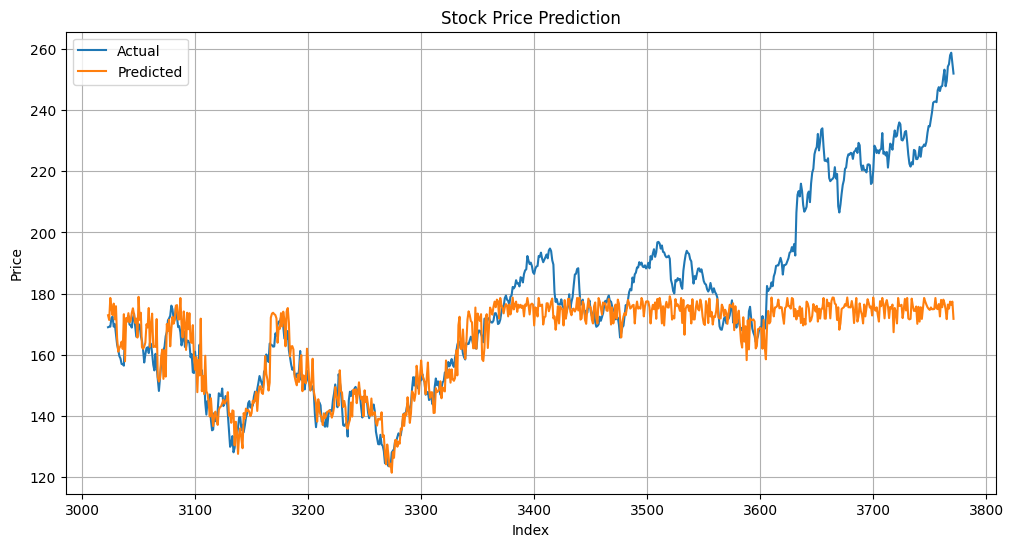

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Stock Price Prediction")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.savefig("../plots/aapl_forecast.png")
plt.show()


In [7]:
import numpy as np

# Direction of real and predicted prices
actual_direction = np.sign(y_test.values[1:] - y_test.values[:-1])
predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])

# Accuracy of direction prediction
directional_accuracy = (actual_direction == predicted_direction).mean()
print(f"Directional Accuracy: {directional_accuracy:.2%}")


Directional Accuracy: 52.54%


In [8]:
# Simulated trading strategy:
# Buy when prediction increases, hold/cash otherwise
signals = np.sign(np.append([0], np.diff(y_pred)))
returns = np.append([0], np.diff(y_test.values))

# Strategy return: only earn when signal matches price move
strategy_returns = signals * returns
cumulative_returns = np.cumsum(strategy_returns)

print(f"Total return from strategy: {cumulative_returns[-1]:.2f}")

Total return from strategy: 85.32


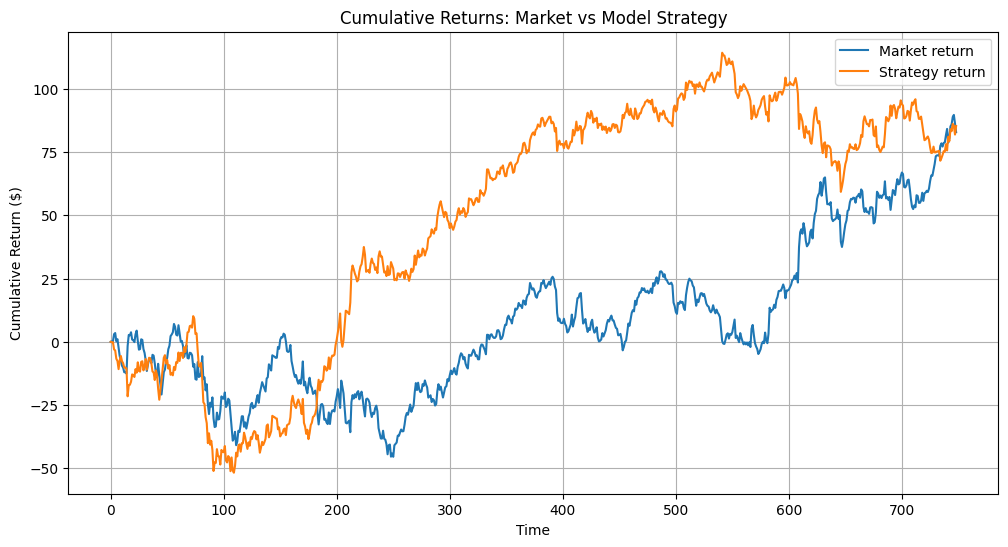

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(returns), label="Market return")
plt.plot(cumulative_returns, label="Strategy return")
plt.title("Cumulative Returns: Market vs Model Strategy")
plt.xlabel("Time")
plt.ylabel("Cumulative Return ($)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Approximate number of trading days in a year
trading_days = 252

# Compute daily return from cumulative series
daily_strategy_return = strategy_returns
daily_market_return = returns

# Annualized return = (1 + daily mean return) ** trading_days - 1
strategy_annualized = (1 + daily_strategy_return.mean()) ** trading_days - 1
market_annualized = (1 + daily_market_return.mean()) ** trading_days - 1

print(f"Annualized return of strategy: {strategy_annualized:.2%}")
print(f"Annualized return of market: {market_annualized:.2%}")


Annualized return of strategy: 64065761165026.71%
Annualized return of market: 30619294625994.47%


In [11]:
from model import train_model_with_tuning

model2, X_test2, y_test2, y_pred2, rmse2, best_params = train_model_with_tuning(df)
print("Tuned model RMSE:", rmse2)
print("Best parameters:", best_params)

Tuned model RMSE: 24.220493443885513
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [12]:
from model import train_classification_model

clf, X_test_cls, y_test_cls, y_pred_cls, acc = train_classification_model(df)
print("Classification Accuracy (up/down):", f"{acc:.2%}")


Classification Accuracy (up/down): 49.67%


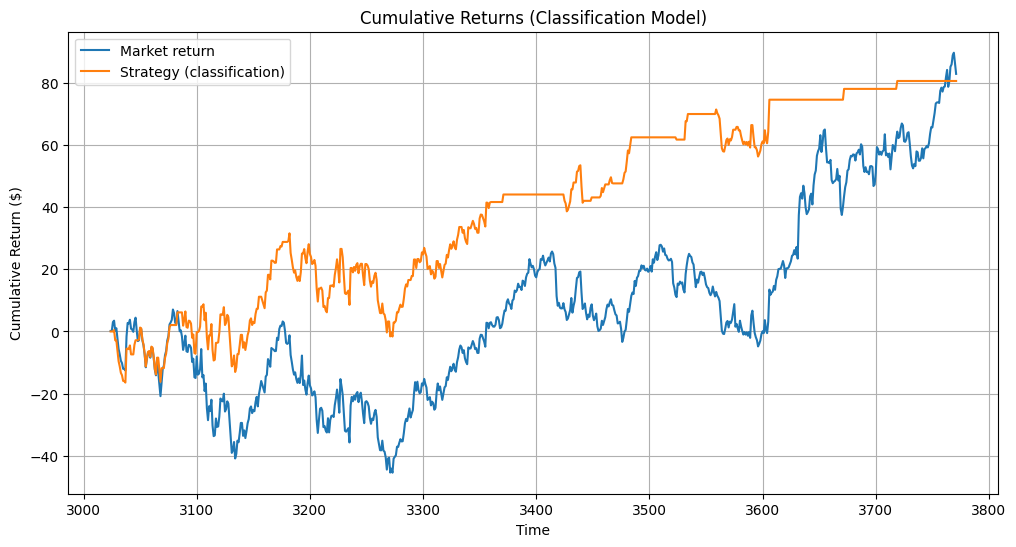

In [14]:
# Simulated strategy from classification prediction
# 1 = buy, 0 = no action
#price_changes = df['Close'].diff().shift(-1).iloc[X_test_cls.index]
price_changes = df.loc[X_test_cls.index, 'Close'].diff().shift(-1)

strategy_cls_returns = price_changes * y_pred_cls
market_cls_returns = price_changes

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(market_cls_returns), label="Market return")
plt.plot(np.cumsum(strategy_cls_returns), label="Strategy (classification)")
plt.title("Cumulative Returns (Classification Model)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return ($)")
plt.legend()
plt.grid(True)
plt.show()
